In [1]:
import oocgcm.test.signals as sig
import oocgcm.filtering.linearfilters as tf
import xarray as xr
import pylab as plt
import numpy as np
from dask.dot import dot_graph
from dask.diagnostics import ProgressBar
import unittest
%matplotlib inline

In [2]:
sigdir = "../signals/"
test_file = 'ORCA025_SSH_SWPAC.nc'

Here is an example of simulated sea surface height from the NEMO model run at 1/4°, that is represented by an xarray.DataArray object. Note that dask array can be used by precising chunks.

In [3]:
signal_xyt = xr.open_dataset(sigdir + test_file, decode_times=False)['sossheig'].chunk(chunks={'time_counter': 50})
print signal_xyt

<xarray.DataArray 'sossheig' (time_counter: 300, y: 184, x: 224)>
dask.array<xarray-..., shape=(300, 184, 224), dtype=float64, chunksize=(50, 184, 224)>
Coordinates:
  * time_counter  (time_counter) float64 73.04 nan nan nan nan nan nan nan ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...


A window object that is linked to the previous data is created by the following line:

In [4]:
win1D = signal_xyt.win

### Temporal filtering: Boxcar window

A boxcar window object that will be applied along the time dimension is simply be defined by setting its different properties:

In [5]:
win1D.set(window_name='boxcar', n=[5], dims=['time_counter'])
print win1D

Window [name->boxcar,dims->['time_counter'],order->{'time_counter': 5}]


The weight distribution and the frequency response of the window may be plotted for one dimensional windows using the plot method: 

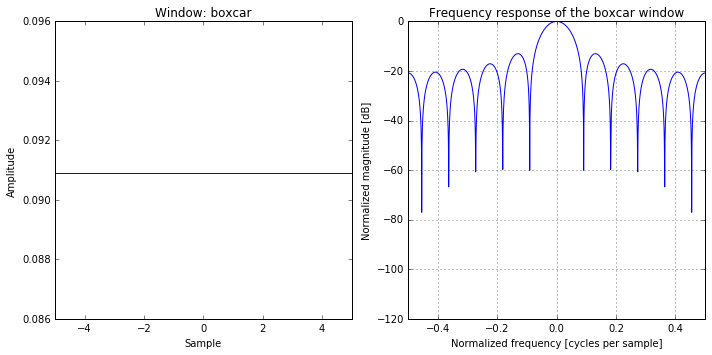

In [6]:
win1D.plot()

This window can now be applied on the data by the associated procedure:

In [7]:
signal_LF_box = win1D.apply(compute=True)

[########################################] | 100% Completed |  1.1s


By default the filtering is computed when using the apply function. If compute is set to False, the filtering will be computed when the output data is required. This allows the definition of several dask object before the global computation is performed.

### Temporal filtering: Lanczos window

Setting now different properties to use a Lanczos window:

Window [name->lanczos,dims->['time_counter'],order->{'time_counter': 5}]


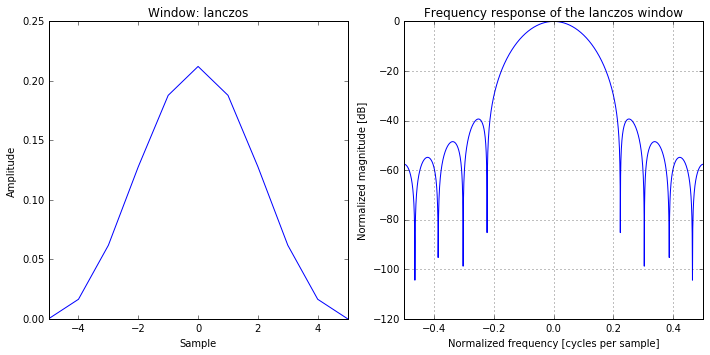

In [8]:
win1D.set(window_name='lanczos', n=[5], dims=['time_counter'], fc=0.1)
print win1D
win1D.plot()

In [9]:
signal_LF_lcz = win1D.apply(compute=True)

[########################################] | 100% Completed |  0.8s


The following figure gives the comparison between the boxcar and the lanczos window applied for the low-pass filtering at one grid point of the dataset.

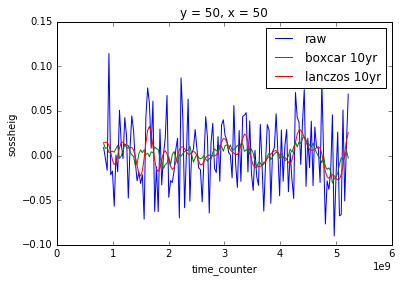

In [10]:
signal_xyt.isel(x=50, y=50).plot()
signal_LF_box.isel(x=50, y=50).plot(color='g')
signal_LF_lcz.isel(x=50, y=50).plot(color='r')
plt.legend(['raw', 'boxcar 10yr', 'lanczos 10yr'])

### Spatial filtering

The window object extend to multidimensional filtering such bidimensional spatial filtering. The filtering method used is able to deal with missing data or coastline by reweighting the filters weights. For example, a 2D Lanczos window may thus be associated to a dataset.

In [11]:
signal_xyt = xr.open_dataset(sigdir + test_file, decode_times=False)['sossheig'].chunk(chunks={'x': 40, 'y':40})
win_box2D = signal_xyt.win
win_box2D.set(window_name='lanczos', n=[24, 24], dims=['x', 'y'], fc=0.0416)
print signal_xyt
print win_box2D

<xarray.DataArray 'sossheig' (time_counter: 300, y: 184, x: 224)>
dask.array<xarray-..., shape=(300, 184, 224), dtype=float64, chunksize=(300, 40, 40)>
Coordinates:
  * time_counter  (time_counter) float64 73.04 nan nan nan nan nan nan nan ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Window [name->lanczos,dims->['x', 'y'],order->{'y': 24, 'x': 24}]


In [12]:
signal_LS = win_box2D.apply()

[########################################] | 100% Completed |  3min  8.3s


##### Original dataset
Temporal standard deviation of the raw timeseries:

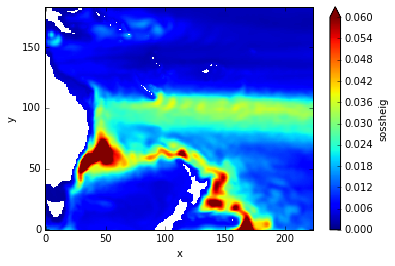

In [13]:
# Original dataset
signal_xyt.std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)

##### Large Scales (>6°)
Temporal standard deviation of the large field:

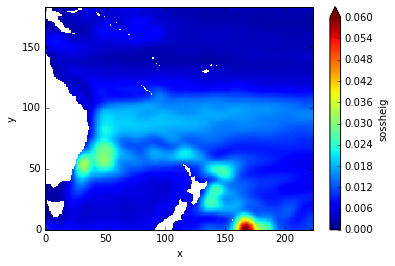

In [14]:
# Large-scale (>6°) dataset
signal_LS.std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)

##### Small Scales (<6°)
Temporal standard deviation of the large field:

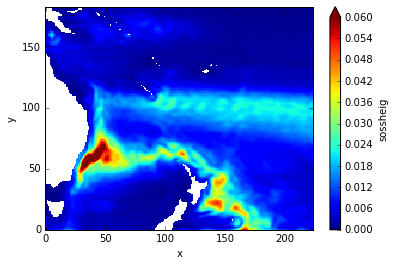

In [15]:
# Small-scale (<6°) dataset
(signal_xyt-signal_LS).std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)